# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Dropout2d
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

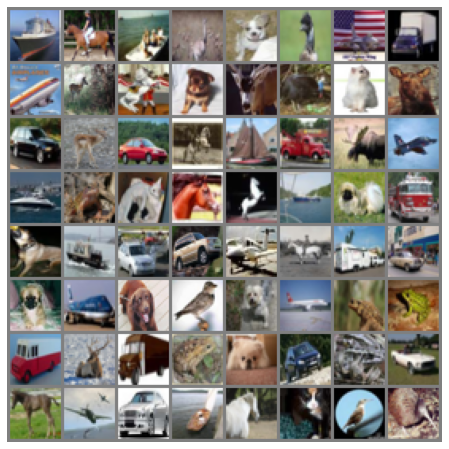

In [4]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [20]:
n_classes = len(set(test_set.targets))


class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

# code modified from https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model,self).__init__()
        # set the number of classes
        self.num_classes = num_classes
        
        # set up 3 convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # set up 3 fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flattening
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = x.view(-1, 64 * 4 * 4)
        
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [21]:
# set the loss criteria to be cross entropy
loss_fn = nn.CrossEntropyLoss()  # Your code here!

# use SGD optimizer
# add momentum and l2 regularization
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #, weight_decay=1e-5)  # Your code here!

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [22]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.05525742  0.16510665 -0.09494725  0.02706046 -0.11820434  0.09144587
   0.13955197  0.03832022  0.01836753 -0.00659163]
 [ 0.01567224  0.14051801 -0.09025618  0.05695923 -0.09386355  0.04267295
   0.10556857 -0.01167733  0.04253543  0.02458811]]
Output probabilities:
[[0.10202623 0.11387248 0.08779682 0.09918959 0.08577848 0.10578603
  0.11099937 0.10031275 0.09833107 0.09590718]
 [0.09899522 0.11215898 0.08904511 0.10316798 0.08872448 0.10170458
  0.1083068  0.09632444 0.1016906  0.0998818 ]]


In [23]:
batch_size = 64
num_epochs = 20
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        # get the inputs
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, compute gradients, backwards, optimize
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.19340625
             test accuracy: 0.3195
Step 1000    training accuracy: 0.38431766055045874
             test accuracy: 0.4531
Step 1500    training accuracy: 0.44415625
             test accuracy: 0.4753
Step 2000    training accuracy: 0.505913130733945
             test accuracy: 0.5746
Step 2500    training accuracy: 0.5630073051948052
             test accuracy: 0.6034
Step 3000    training accuracy: 0.589375
             test accuracy: 0.6231
Step 3500    training accuracy: 0.6253780241935484
             test accuracy: 0.6443
Step 4000    training accuracy: 0.6673611111111111
             test accuracy: 0.6564
Step 4500    training accuracy: 0.66284375
             test accuracy: 0.6686
Step 5000    training accuracy: 0.6812601461038961
             test accuracy: 0.701
Step 5500    training accuracy: 0.7055288461538461
             test accuracy: 0.7114
Step 6000    training accuracy: 0.70675
             test accuracy: 0.6902
Step 6500    t

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

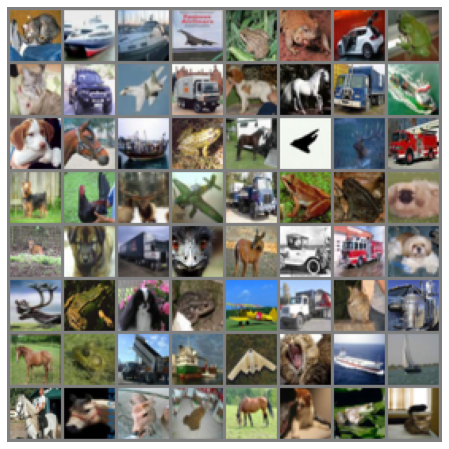

    TRUE        PREDICTED
-----------------------------
     cat           dog     
    ship          ship     
    ship        airplane   
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile       truck    
    frog          deer     
     cat           dog     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         truck    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog          bi

In [24]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [25]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [26]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.743


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


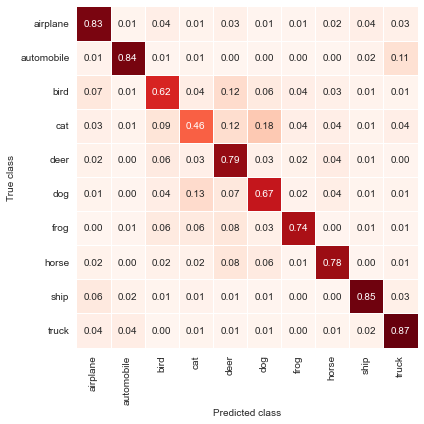

In [27]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

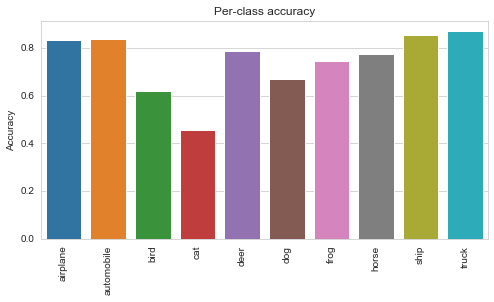

In [28]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?
   - Yes - 74.3% accuracy on the test set reached!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.



 ###  Answer:

#### 2. Explanation of experiments and their results.
- I started with a CNN with 2 convolutional layers and 3 fully connected layers (by following the [pytorch tutorial on CIFAR10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html))
- changing it to 2 convolutional layers and 4 fully connected layers caused the test accuracy to start out higher than the train accuracy for the first several epochs. Then it started severely overfitting so I only kept 3 fully connected layers.
- I experimented with the amount of neurons in the fully connected layers - starting with 1024 hidden layers -> 512 hidden layers, and other combinations. Having too many neurons caused severe overfitting (train 96%, test 63% accuracy)
- I was surprised with how easily the model overfitted
- changing learning rate from 0.0001 to lower values (such as 0.01 and 0.1) increased the accuracy
- Adding momentum = 0.9 helped the accuracy, along with adding dropout after the 2nd conv layer
- The only method I found to reduce overfitting was to adjust the architecture and use 3 convolutional layers and 3 fully connected layers

#### 3. Key lessons/insights gained from this exercise.
- it is necessary to try out a large combination of different values!! this is much different than hyperparameter tuning in standard ML methods (basically just doing cross-validation to pick the best model)
   - the [article](https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844) helped me figure out how to implement dropout, pooling, etc. in a different way than the Pytorch basic documentation did.
- a lot of things can cause overfitting..
   - having too many epochs
   - having too many fully connected layers and/or too many hidden neurons in them
- what helped fix overfitting?
   - using 3 conv layers + 3 fully connected layers
   - adjusting the amount of hidden neurons in the fully connected layers
   - adding dropout
- it is difficult to determine why certain classes are scoring more poorly.. `cat` was always the hardest class to identify in all of my many model architectures.




# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [29]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**

Chapter 3 Exercise: Verify that the standard deviation of $z=\sum_j w_j x_j+b$ in the paragraph above is $\sqrt{3/2}$. It may help to know that: (a) the variance of a sum of independent random variables is the sum of the variances of the individual random variables; and (b) the variance is the square of the standard deviation.

$$
\text{var}(z) = \text{var}(\sum_j w_j x_j)+\underbrace{\text{Var}(b)}_{= 1 \text{ (}b \sim \mathcal{N(0,1)})} \\
= \sum_j \text{var}(w_j x_j) + 1 \\
= \sum_j x_j^2 \underbrace{\text{var}(w_j)}_{ (1/\sqrt{n_{in}})^2} + 1 \\
$$

$\text{ } \frac{n_{in}}{2} \text{ of the } x_j\text{s are }=0, \text{ and }\frac{n_{in}}{2} \text{ are } =1 \text{ , so } $


$$
\text{var}(z) = \frac{n_{in}}{2} \frac{1}{n_{in}} + 1\\
\text{var}(z) = \frac{3}{2} \\
\text{standard deviation}(z) = \sqrt{\frac{3}{2}}
$$


